# Thesis

## imports, wandb config and dataset.

In [1]:
from dataset import *
from evaluation import *
from dafc import *
from cfar import *
from trainer import *
from unet import *
from diffusion import *
from inference import *
import numpy as np
from visfuncs import *
import torch
import wandb

### Initialization

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_name = 'detdiff_with_CBBCE'
wandb.init(
    project="New-Radar-diffusion",
    name=run_name,
    notes="Regular diffusion. this experiment is our benchmark - we check if changes are performing better or worse",
    config={
        "SNR": [10],
        "CNR": [15],
        "NU": [0.2, 0.5, 1.0],
        "n_targets": 8,
        "rand_n_targets": True,
        "beta_end": 0.01,
        "beta_start": 0.0001,
        "batch_size":16,
        "num_epochs": 400,
        "noise_steps": 2000,
        "num_workers": 4,
        "dataset_size": 50000,
        "time_emb_dim": 256,
        "learning_rate": 0.0001,        
        "scheduler_type": "cosine",
    },
)
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ari-granevich to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### create datasets

In [3]:
norm_train_loader, norm_val_loader, norm_train_dataset, norm_val_dataset = prep_dataset(config)
print("succefully created diffusion dataset")
dafc_train_loader, dafc_val_loader = prepDAFCdata()
print("succefully created DAFC dataset")

KeyboardInterrupt: 

## Diffusion model

### define model and parameters

In [ ]:
train_loader = norm_train_loader
val_loader = norm_val_loader
cond_unet = DetUNet(in_channels=4, out_channels=2, time_emb_dim=config.time_emb_dim).to(device)

cond_diffusion = StudentTDiffusion(model=cond_unet, scheduler_type=config.scheduler_type, T=config.noise_steps, 
    beta_start=config.beta_start, beta_end=config.beta_end).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4, cooldown=15, min_lr=1e-6, verbose=True)
num_epochs = config.num_epochs

/home/hawk/Desktop/Heavy-Clutter-Detection/finalDiffusion/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Train diffusion model

In [ ]:

best_val_loss = float('inf')
best_mse_loss = float('inf')
train_losses, val_losses, val_psnrs, val_mses = [], [], [], []
e_mse_loss = None
e_rd_loss = None
iq_val_loss = None
rd_val_loss = None

for epoch in range(num_epochs):
    #train_loss, e_mse_loss, e_rd_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    #val_loss, iq_val_loss, rd_val_loss, gen_mse, gen_psnr, rd_mse = validate(cond_diffusion, val_loader, device)

    train_loss= train_det_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = det_validate(cond_diffusion, val_loader, device, lambda_det=0.01)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    scheduler.step(val_loss)

    if gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(cond_diffusion.state_dict(), f"{run_name}.pth")
        print("   --> Best MSE model saved.")

    wandb.log({
        "total train loss": train_loss,
        "total val loss": val_loss,
        "MSE between denoised IQ and clean IQ": gen_mse if gen_mse is not None else float('nan'),
        "generated IQ map PSNR": gen_psnr,
        "learning rate": optimizer.param_groups[0]['lr']  # Optional, log current LR
    })


/home/hawk/Desktop/Heavy-Clutter-Detection/Thesis/trainer.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=device))


Epoch 1/400: Train Loss = 0.0763 | Val Loss = 0.0118
   [Generation Metrics] MSE: 0.9585 | PSNR: 36.69 dB
   --> Best MSE model saved.
Epoch 2/400: Train Loss = 0.0184 | Val Loss = 0.0089
   [Generation Metrics] MSE: 1.1673 | PSNR: 35.84 dB
Epoch 3/400: Train Loss = 0.0132 | Val Loss = 0.0074
   [Generation Metrics] MSE: 1.6460 | PSNR: 34.35 dB
Epoch 4/400: Train Loss = 0.0110 | Val Loss = 0.0067
   [Generation Metrics] MSE: 0.5726 | PSNR: 38.93 dB
   --> Best MSE model saved.
Epoch 5/400: Train Loss = 0.0098 | Val Loss = 0.0060
   [Generation Metrics] MSE: 0.9531 | PSNR: 36.72 dB
Epoch 6/400: Train Loss = 0.0090 | Val Loss = 0.0058
   [Generation Metrics] MSE: 0.5529 | PSNR: 39.08 dB
   --> Best MSE model saved.
Epoch 7/400: Train Loss = 0.0086 | Val Loss = 0.0058
   [Generation Metrics] MSE: 0.3667 | PSNR: 40.87 dB
   --> Best MSE model saved.
Epoch 8/400: Train Loss = 0.0080 | Val Loss = 0.0047
   [Generation Metrics] MSE: 0.3243 | PSNR: 41.40 dB
   --> Best MSE model saved.
Epoch 9

KeyboardInterrupt: 

### inference diffusion model

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7b091f4a1d00>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7b018544cf20, raw_cell="checkpoint_path = "/home/hawk/Desktop/Heavy-Clutte.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/hawk/Desktop/Heavy-Clutter-Detection/Thesis/main.ipynb#X20sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

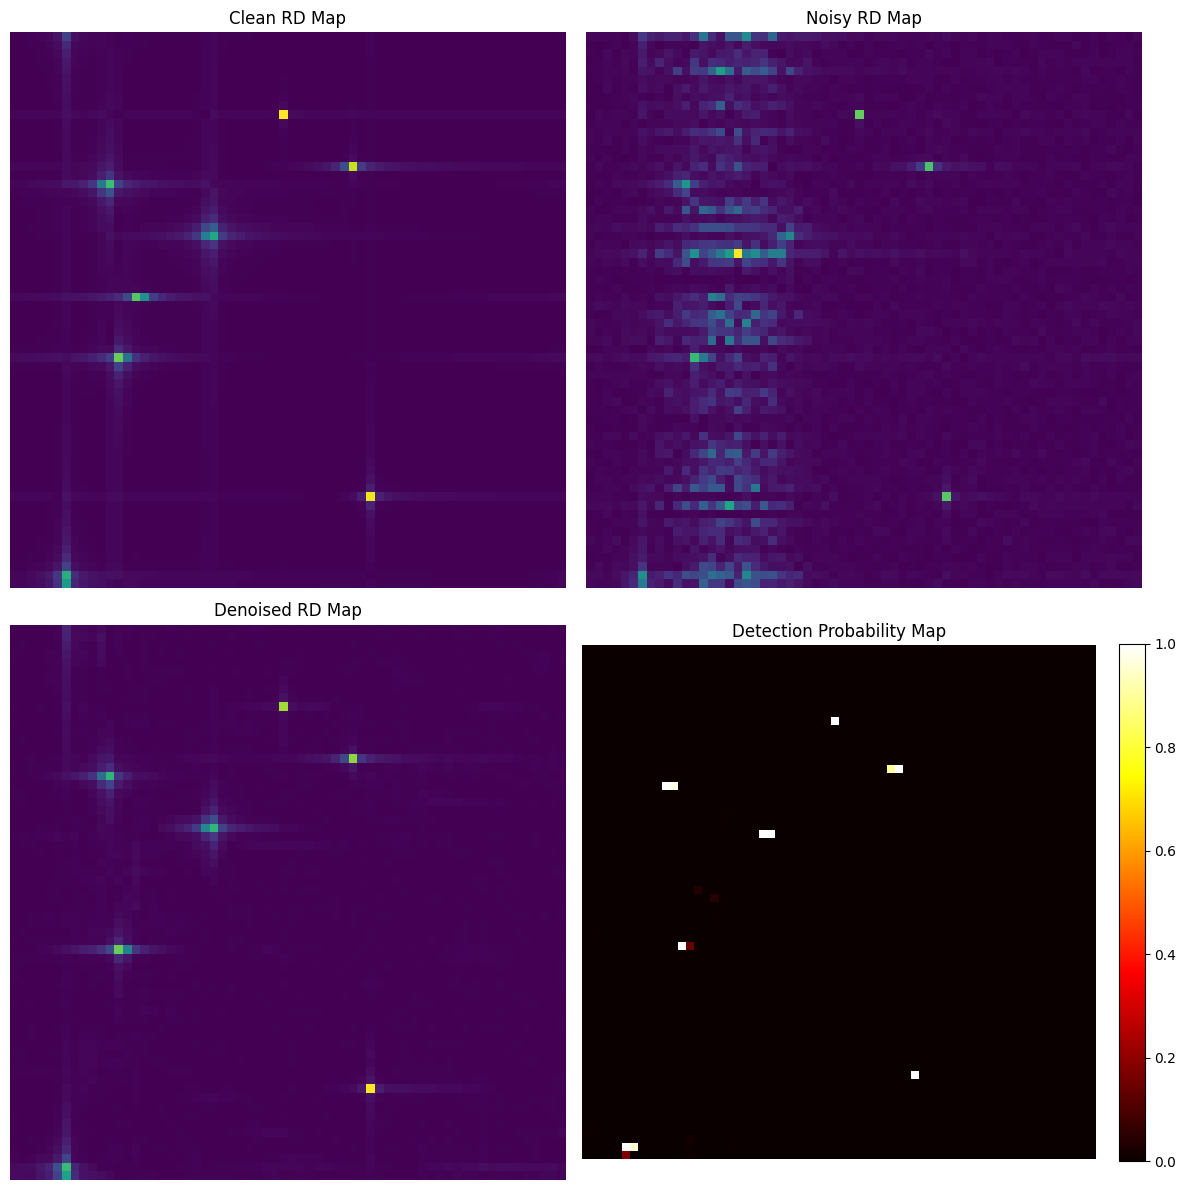

{'clean': array([[0.14302337, 0.19344181, 0.26995382, ..., 0.08014563, 0.10713299,
         0.14302728],
        [0.0855014 , 0.11585335, 0.16195856, ..., 0.04767453, 0.06390776,
         0.08550414],
        [0.06051045, 0.08212245, 0.11499678, ..., 0.03361356, 0.045152  ,
         0.06051271],
        ...,
        [0.15707454, 0.21053171, 0.2916112 , ..., 0.09048586, 0.11903851,
         0.15707652],
        [0.48580676, 0.6537037 , 0.908308  , ..., 0.27647218, 0.3662816 ,
         0.48581547],
        [0.41587174, 0.5612197 , 0.7816703 , ..., 0.23457938, 0.31238276,
         0.41588098]], shape=(64, 64), dtype=float32),
 'noisy': array([[0.34720814, 0.35563904, 0.25961867, ..., 0.24406593, 0.01380345,
         0.34722456],
        [0.08974648, 0.07901055, 0.11987337, ..., 0.16605867, 0.26728362,
         0.08974764],
        [0.1724602 , 0.15623395, 0.4710267 , ..., 0.25035506, 0.27612478,
         0.1724627 ],
        ...,
        [0.20074648, 0.4955244 , 0.20737126, ..., 0.1001825

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7b091f4a1d00>> (for post_run_cell), with arguments args (<ExecutionResult object at 7b018771b770, execution_count=9 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7b018544cf20, raw_cell="checkpoint_path = "/home/hawk/Desktop/Heavy-Clutte.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/hawk/Desktop/Heavy-Clutter-Detection/Thesis/main.ipynb#X20sZmlsZQ%3D%3D> result={'clean': array([[0.14302337, 0.19344181, 0.26995382, ..., 0.08014563, 0.10713299,
        0.14302728],
       [0.0855014 , 0.11585335, 0.16195856, ..., 0.04767453, 0.06390776,
        0.08550414],
       [0.06051045, 0.08212245, 0.11499678, ..., 0.03361356, 0.045152  ,
        0.06051271],
       ...,
       [0.15707454, 0.21053171, 0.2916112 , ..., 0.09048586, 0.11903851,
        0.15707652],
       [0.48580676, 0.6537037 , 0.908308  , ..., 0.27647218, 0.3

BrokenPipeError: [Errno 32] Broken pipe

In [9]:
checkpoint_path = "/home/hawk/Desktop/Heavy-Clutter-Detection/Thesis/detdiff_with_CBBCE.pth"
run_inference(cond_diffusion , norm_val_dataset, checkpoint_path, device)

## Visualize normalized dataset

In [ ]:
# visualize_sample(norm_train_dataset, sample_index=1500)

## Train DAFC neural network

In [ ]:
#train range model
# train_range_dafc(dafc_train_loader, dafc_val_loader)
# train_doppler_dafc(dafc_train_loader, dafc_val_loader)

## View CFAR performance

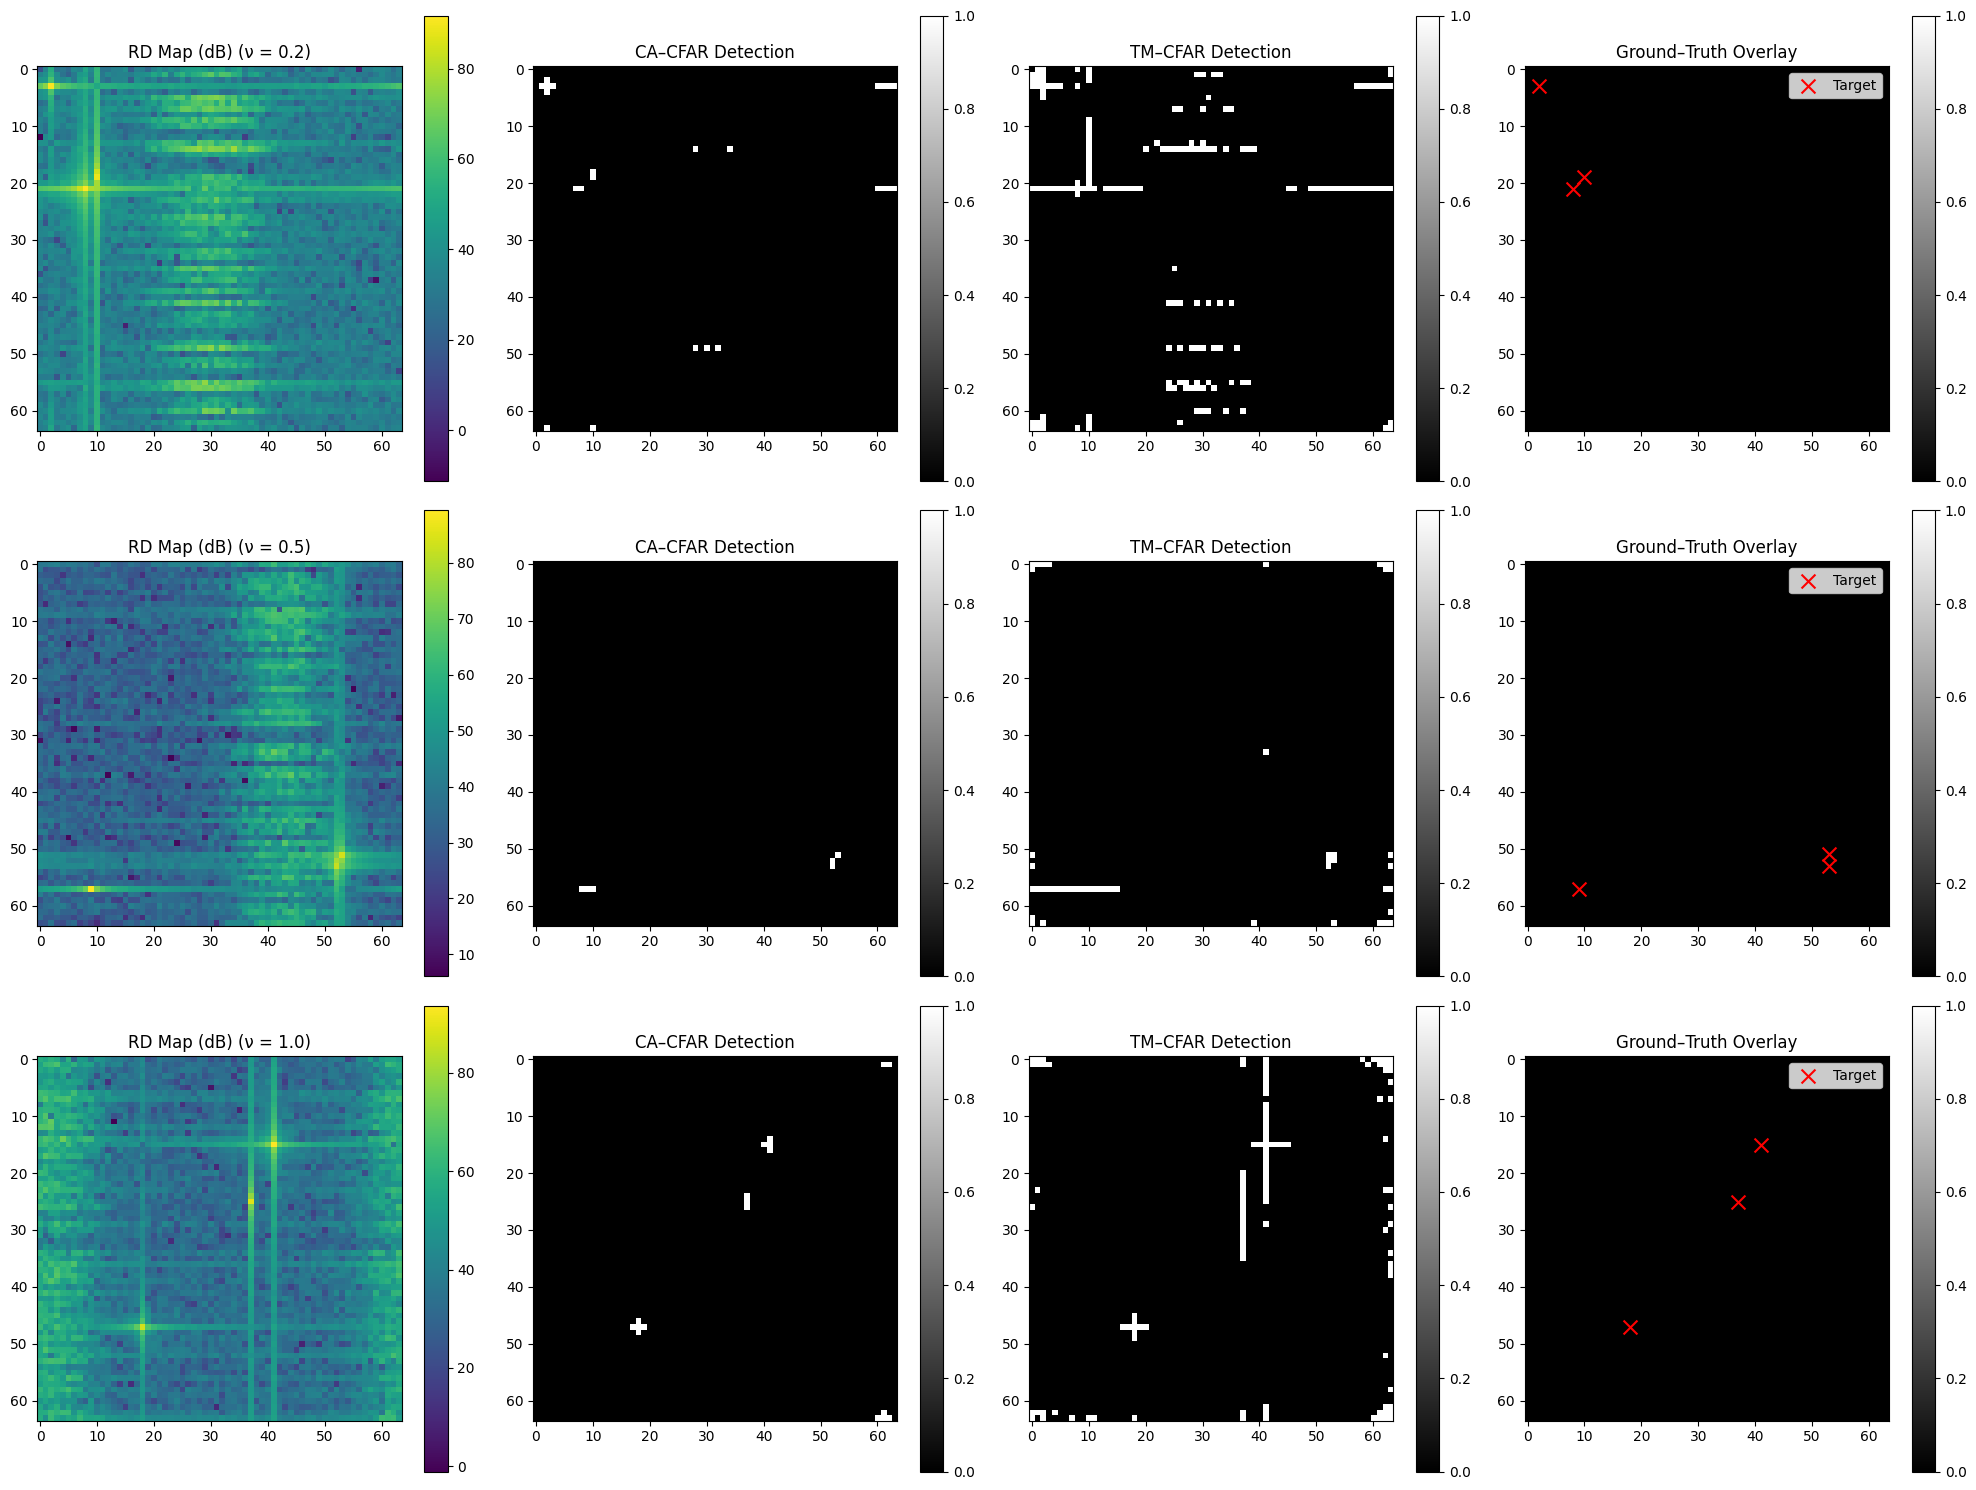

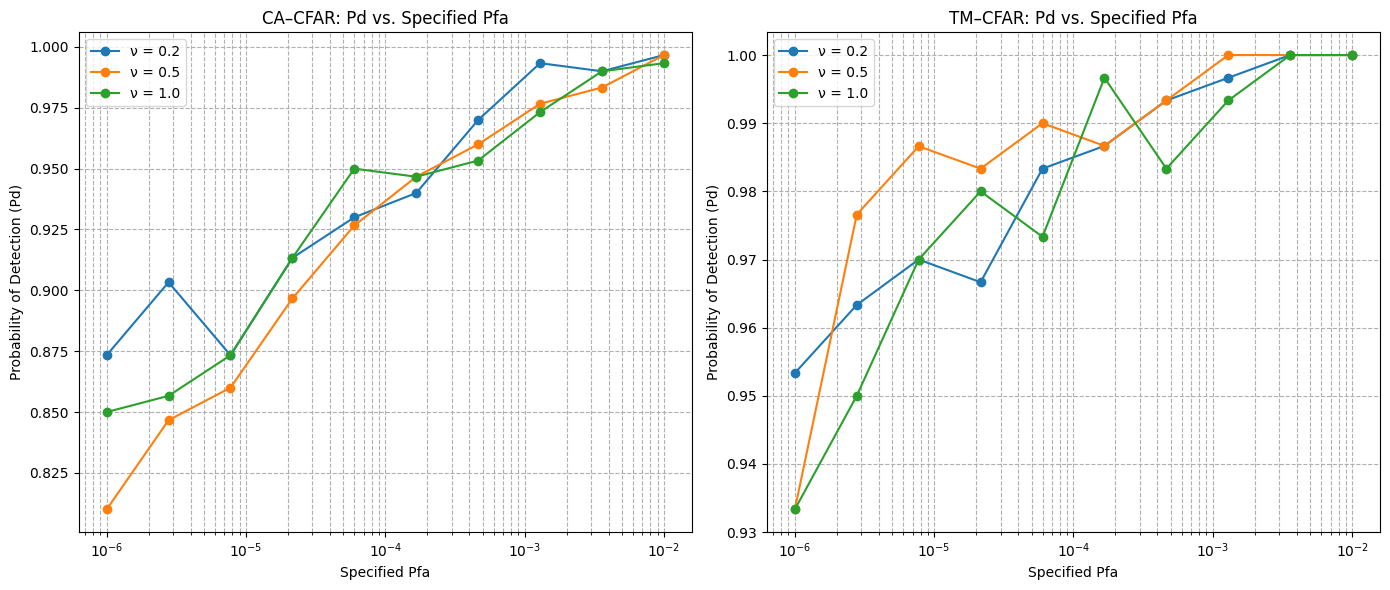

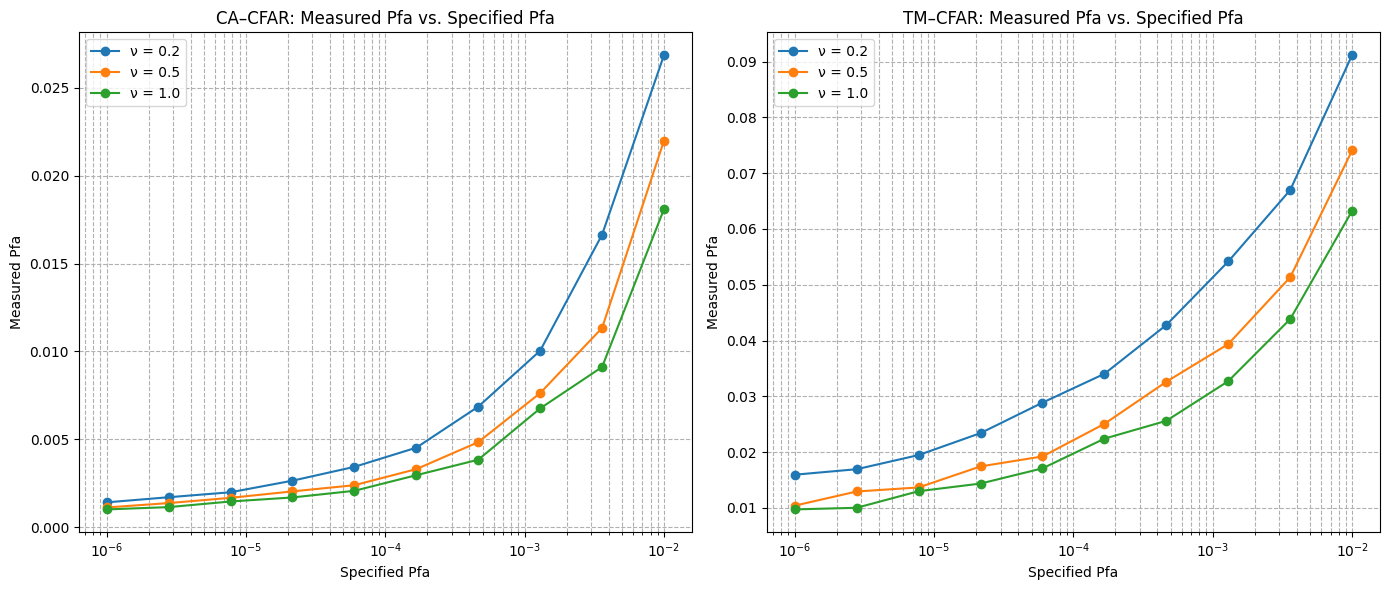

In [ ]:
if __name__ == '__main__':
    torch.manual_seed(0)
    np.random.seed(0)

    # ------------------------------
    # Part 1: Single–frame Demo and Ground–Truth Overlay
    # ------------------------------
    # Use three clutter “spikiness” (ν) values for demonstration.
    nu_values = [0.2, 0.5, 1.0]
    num_train = 4       # training cells per side
    num_guard = 1       # guard cells per side
    trim_ratio = 0.25   # for TM–CFAR
    demo_Pfa = 1e-4     # chosen false–alarm parameter for the demo

    # For demonstration, we will generate one frame per ν value and show:
    # (a) the RD map (in dB),
    # (b) the CA–CFAR detection map,
    # (c) the TM–CFAR detection map,
    # (d) an overlay of the ground–truth target positions on the RD map.
    fig_demo, axs_demo = plt.subplots(len(nu_values), 4, figsize=(20, 5 * len(nu_values)))
    for idx, nu_val in enumerate(nu_values):
        dataset = DAFCDataset(num_samples=1, n_targets=3, random_n_targets=False, nu=nu_val)
        S, C, IQ_map, clean_RD_map, RD_map, rd_label = dataset[0]
        RD_map_mag = torch.abs(RD_map).detach().numpy()
        gt = rd_label.detach().numpy()
        # Apply CFAR detectors with the demo_Pfa:
        ca_detection = ca_cfar_2d(RD_map_mag, num_train, num_guard, demo_Pfa)
        tm_detection = tm_cfar_2d(RD_map_mag, num_train, num_guard, trim_ratio, demo_Pfa)
        
        # (a) RD map in dB
        im0 = axs_demo[idx, 0].imshow(20 * np.log10(RD_map_mag + 1e-12), cmap='viridis')
        axs_demo[idx, 0].set_title(f'RD Map (dB) (ν = {nu_val})')
        fig_demo.colorbar(im0, ax=axs_demo[idx, 0])
        
        # (b) CA–CFAR detection map
        im1 = axs_demo[idx, 1].imshow(ca_detection, cmap='gray')
        axs_demo[idx, 1].set_title('CA–CFAR Detection')
        fig_demo.colorbar(im1, ax=axs_demo[idx, 1])
        
        # (c) TM–CFAR detection map
        im2 = axs_demo[idx, 2].imshow(tm_detection, cmap='gray')
        axs_demo[idx, 2].set_title('TM–CFAR Detection')
        fig_demo.colorbar(im2, ax=axs_demo[idx, 2])
        
        # (d) Overlay ground–truth targets on the RD map.
        axs_demo[idx, 3].imshow(0*20 * np.log10(RD_map_mag + 1e-12), cmap='gray')
        # Find indices where ground–truth label equals 1
        r_inds, d_inds = np.where(gt == 1)
        axs_demo[idx, 3].scatter(d_inds, r_inds, marker='x', color='red', s=100, label='Target')
        axs_demo[idx, 3].set_title('Ground–Truth Overlay')
        fig_demo.colorbar(im2, ax=axs_demo[idx, 3])
        axs_demo[idx, 3].legend()
    plt.tight_layout()
    plt.show()
    
    # ------------------------------
    # Part 2: Monte Carlo Simulation to Plot ROC Curves (Pd vs Pfa)
    # ------------------------------
    # We sweep over a range of specified Pfa values (for threshold setting)
    pfa_values = np.logspace(-6, -2, num=10)
    num_trials = 100  # number of Monte Carlo trials per point
    # For each CFAR method and for each nu, we store the resulting Pd and the measured Pfa.
    # (We use fixed n_targets=3 and random_n_targets=False to have reproducible ground truth.)
    results_ca = {nu: {'Pd': [], 'Pfa_meas': []} for nu in nu_values}
    results_tm = {nu: {'Pd': [], 'Pfa_meas': []} for nu in nu_values}

    for nu_val in nu_values:
        for pfa in pfa_values:
            # CA–CFAR simulation:
            pd_ca, pfa_meas_ca = simulate_cfar_performance(ca_cfar_2d, pfa, nu_val, num_trials=num_trials,
                                                            n_targets=3, random_n_targets=False,
                                                            num_train=num_train, num_guard=num_guard)
            results_ca[nu_val]['Pd'].append(pd_ca)
            results_ca[nu_val]['Pfa_meas'].append(pfa_meas_ca)
            # TM–CFAR simulation:
            pd_tm, pfa_meas_tm = simulate_cfar_performance(tm_cfar_2d, pfa, nu_val, num_trials=num_trials,
                                                            n_targets=3, random_n_targets=False,
                                                            num_train=num_train, num_guard=num_guard,
                                                            trim_ratio=trim_ratio)
            results_tm[nu_val]['Pd'].append(pd_tm)
            results_tm[nu_val]['Pfa_meas'].append(pfa_meas_tm)
    
    # Plot ROC curves: Pd vs. specified Pfa (x-axis, log-scale)
    fig_roc, axs_roc = plt.subplots(1, 2, figsize=(14, 6))
    
    # CA–CFAR ROC plot:
    for nu_val in nu_values:
        axs_roc[0].plot(pfa_values, results_ca[nu_val]['Pd'], marker='o', label=f'ν = {nu_val}')
    axs_roc[0].set_xscale('log')
    axs_roc[0].set_xlabel('Specified Pfa')
    axs_roc[0].set_ylabel('Probability of Detection (Pd)')
    axs_roc[0].set_title('CA–CFAR: Pd vs. Specified Pfa')
    axs_roc[0].grid(True, which='both', ls='--')
    axs_roc[0].legend()
    
    # TM–CFAR ROC plot:
    for nu_val in nu_values:
        axs_roc[1].plot(pfa_values, results_tm[nu_val]['Pd'], marker='o', label=f'ν = {nu_val}')
    axs_roc[1].set_xscale('log')
    axs_roc[1].set_xlabel('Specified Pfa')
    axs_roc[1].set_ylabel('Probability of Detection (Pd)')
    axs_roc[1].set_title('TM–CFAR: Pd vs. Specified Pfa')
    axs_roc[1].grid(True, which='both', ls='--')
    axs_roc[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Optionally, you can also plot the measured Pfa (averaged over Monte Carlo runs)
    fig_pfa, axs_pfa = plt.subplots(1, 2, figsize=(14, 6))
    for nu_val in nu_values:
        axs_pfa[0].plot(pfa_values, results_ca[nu_val]['Pfa_meas'], marker='o', label=f'ν = {nu_val}')
    axs_pfa[0].set_xscale('log')
    axs_pfa[0].set_xlabel('Specified Pfa')
    axs_pfa[0].set_ylabel('Measured Pfa')
    axs_pfa[0].set_title('CA–CFAR: Measured Pfa vs. Specified Pfa')
    axs_pfa[0].grid(True, which='both', ls='--')
    axs_pfa[0].legend()

    for nu_val in nu_values:
        axs_pfa[1].plot(pfa_values, results_tm[nu_val]['Pfa_meas'], marker='o', label=f'ν = {nu_val}')
    axs_pfa[1].set_xscale('log')
    axs_pfa[1].set_xlabel('Specified Pfa')
    axs_pfa[1].set_ylabel('Measured Pfa')
    axs_pfa[1].set_title('TM–CFAR: Measured Pfa vs. Specified Pfa')
    axs_pfa[1].grid(True, which='both', ls='--')
    axs_pfa[1].legend()

    plt.tight_layout()
    plt.show()


## Evaluate DAFC performance

In [ ]:
print("using device: ", device)
range_model, doppler_model = load_trained_models()
tester = CombinedRadarTester(range_model, doppler_model, device)

# Test parameters
nu_values = [0.2, 0.5, 1.0]

# PD vs PFA test (SCNR = 0dB)
pd_pfa_results = {}
print("Running PD vs PFA test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa = tester.evaluate_pd_pfa(nu, scnr=0)
    pd_pfa_results[nu] = (pd, pfa)
plot_pd_pfa(pd_pfa_results)

# PD vs SCNR test (PFA = 5e-4)
pd_scnr_results = {}
print("\nRunning PD vs SCNR test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa, scnr = tester.evaluate_pd_scnr(nu)
    pd_scnr_results[nu] = (pd, pfa, scnr)
plot_pd_scnr(pd_scnr_results)

using device:  cuda
Loaded range model successfully
Loaded doppler model successfully
Running PD vs PFA test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]

Found threshold = 0.1267, PFA = 0.000010 after 12 iterations


Found threshold = 0.0798, PFA = 0.000050 after 12 iterations


Found threshold = 0.0845, PFA = 0.000100 after 11 iterations


Found threshold = 0.0363, PFA = 0.000499 after 13 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:17<00:35, 17.71s/it]

Found threshold = 0.0248, PFA = 0.001002 after 13 iterations


Found threshold = 0.1274, PFA = 0.000010 after 11 iterations


Found threshold = 0.0675, PFA = 0.000050 after 13 iterations


Found threshold = 0.0693, PFA = 0.000100 after 10 iterations


Found threshold = 0.0300, PFA = 0.000500 after 12 iterations


Testing PFAs: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

Found threshold = 0.0182, PFA = 0.000997 after 13 iterations



Testing clutter conditions:  67%|██████▋   | 2/3 [00:35<00:17, 17.74s/it]

Found threshold = 0.0968, PFA = 0.000010 after 13 iterations


Found threshold = 0.0815, PFA = 0.000050 after 11 iterations


Found threshold = 0.0618, PFA = 0.000099 after 12 iterations


Found threshold = 0.0276, PFA = 0.000497 after 12 iterations


Testing PFAs: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

Found threshold = 0.0183, PFA = 0.001007 after 12 iterations



Testing clutter conditions: 100%|██████████| 3/3 [00:53<00:00, 17.76s/it]



Running PD vs SCNR test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]

Found threshold = 0.0337, PFA = 0.000499 after 11 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:39<01:19, 39.84s/it]

Found threshold = 0.0334, PFA = 0.000498 after 12 iterations


Testing clutter conditions:  67%|██████▋   | 2/3 [01:19<00:39, 39.95s/it]

Found threshold = 0.0259, PFA = 0.000500 after 11 iterations


Testing clutter conditions: 100%|██████████| 3/3 [01:59<00:00, 39.89s/it]


## compare CFAR and DAFC performance

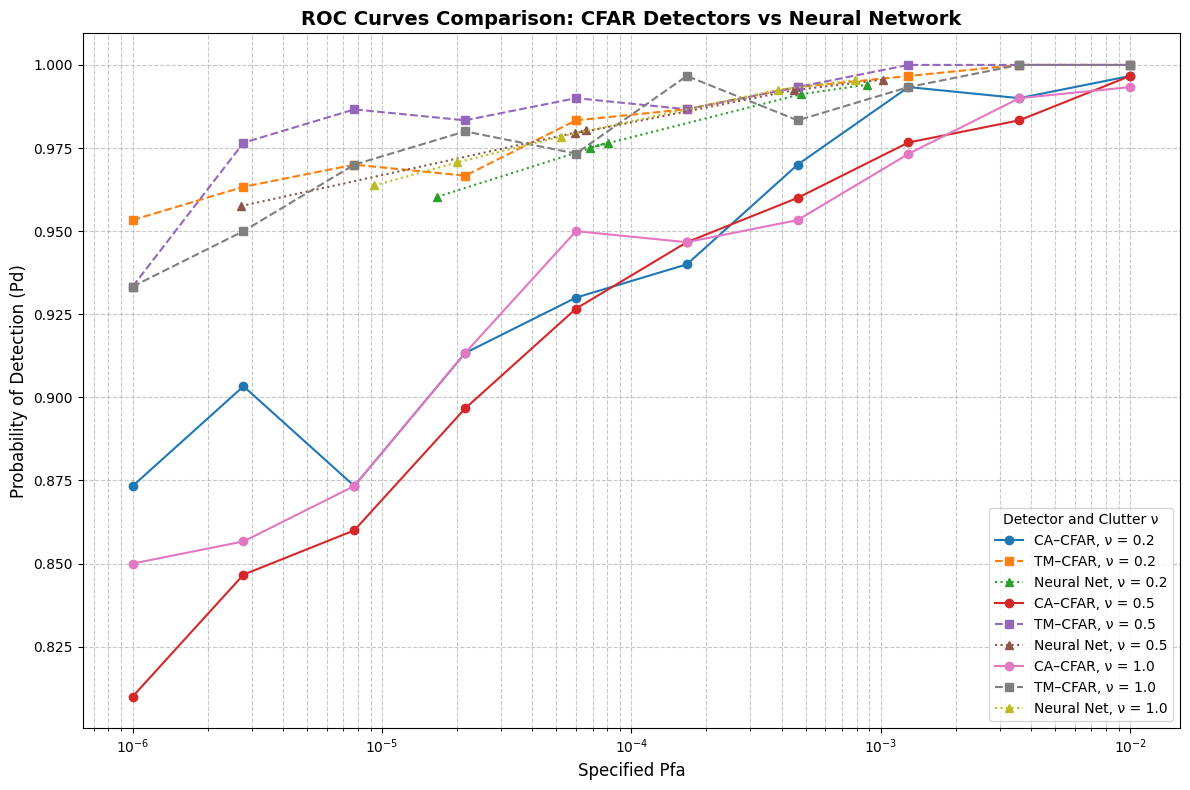

In [ ]:
# Example: pfa_values used for the CFAR simulations
# (In your CFAR simulation, pfa_values = np.logspace(-6, -2, num=10))
# Ensure these are defined in your scope.
# pfa_values = np.logspace(-6, -2, num=10)

plt.figure(figsize=(12, 8))
markers = {'CA': 'o', 'TM': 's', 'NN': '^'}
linestyles = {'CA': '-', 'TM': '--', 'NN': ':'}

# Loop over each clutter condition (ν value)
for nu in nu_values:
    # Plot CA–CFAR results
    plt.plot(
        pfa_values, 
        results_ca[nu]['Pd'], 
        marker=markers['CA'], linestyle=linestyles['CA'],
        label=f'CA–CFAR, ν = {nu}'
    )
    
    # Plot TM–CFAR results
    plt.plot(
        pfa_values, 
        results_tm[nu]['Pd'], 
        marker=markers['TM'], linestyle=linestyles['TM'],
        label=f'TM–CFAR, ν = {nu}'
    )
    
    # Plot Neural Network results
    # Here, pd_pfa_results[nu] returns a tuple (pd_array, pfa_array)
    nn_pd, nn_pfa = pd_pfa_results[nu]
    plt.plot(
        nn_pfa, 
        nn_pd, 
        marker=markers['NN'], linestyle=linestyles['NN'],
        label=f'Neural Net, ν = {nu}'
    )

plt.xscale('log')
plt.xlabel('Specified Pfa', fontsize=12)
plt.ylabel('Probability of Detection (Pd)', fontsize=12)
plt.title('ROC Curves Comparison: CFAR Detectors vs Neural Network', fontsize=14, fontweight='bold')
plt.grid(True, which='both', ls='--', alpha=0.7)
plt.legend(title='Detector and Clutter ν', fontsize=10)
plt.tight_layout()
plt.show()


## other performance viewers

In [ ]:
def simulate_diffusion_performance(cond_diffusion, norm_val_dataset, device, thresholds, num_trials=100):
    """
    Runs Monte–Carlo trials of your diffusion model, binarizes the denoised RD map
    at each threshold, and computes Pd / measured Pfa.

    Args:
        cond_diffusion: loaded and .eval() diffusion model on `device`.
        norm_val_dataset: dataset yielding (signals_norm, rd_signals_norm, IQs_norm, RDs_norm, clutter_all, gauss_all, labels, scnr_dBs).
        device: torch.device.
        thresholds: list or np.array of scalar thresholds on |denoised map|.
        num_trials: how many samples to test.

    Returns:
        pd_list: list of Pd (hit rate) per threshold.
        pfa_list: list of measured Pfa per threshold.
    """
    # Ensure model in eval mode
    cond_diffusion.to(device).eval()

    pd_list, pfa_list = [], []

    # Pre‐compute fixed sample_shape from one example
    _, _, _, RDs_norm, _, _, rd_label,_ = norm_val_dataset[0]
    H, W = RDs_norm.shape
    sample_shape = (1, 2, H, W)

    for thr in thresholds:
        tp, fp = 0, 0
        total_pos = 0
        total_neg = 0

        for idx in range(num_trials):
            # unpack one cluttered RD map + its ground truth
            _, _, _, RDs_norm, _, _, rd_label, _ = norm_val_dataset[idx]
            IQ = RDs_norm.to(device)
            cond_img = torch.cat([IQ.real.unsqueeze(0), IQ.imag.unsqueeze(0)], dim=0)
            cond_img = cond_img.unsqueeze(0)  # (1,2,H,W)

            with torch.no_grad():
                gen = cond_diffusion.sample(cond_img, sample_shape)  # (1,2,H,W)
            # rebuild complex
            denoised = torch.complex(gen[0,0], gen[0,1]).cpu().numpy()
            det_map = (np.abs(denoised) > thr).astype(int)

            gt = rd_label.numpy().astype(int)
            tp += np.sum((det_map == 1) & (gt == 1))
            fp += np.sum((det_map == 1) & (gt == 0))
            total_pos += np.sum(gt == 1)
            total_neg += np.sum(gt == 0)

        pd_list.append(tp / total_pos)
        pfa_list.append(fp / total_neg)

    return pd_list, pfa_list


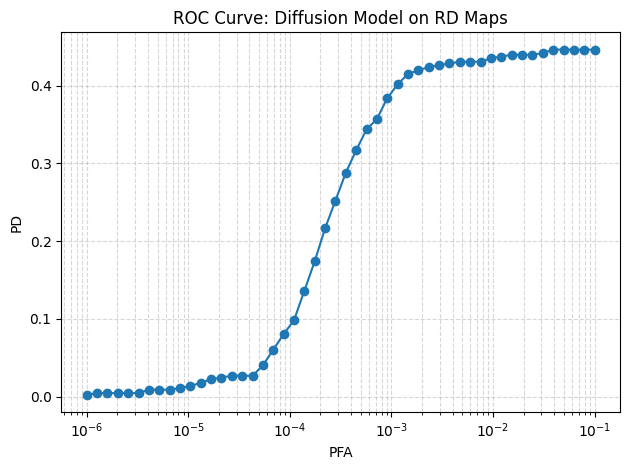

In [ ]:
import torch
import numpy as np

def simulate_diffusion_roc(cond_diffusion, dataset, checkpoint, device, pfa_list):
    """
    Args:
      cond_diffusion : your ConditionalDiffusion instance
      dataset        : a Dataset where __getitem__ returns 
                       (_, _, _, RDs_norm, _, _, labels, _)
      checkpoint     : path to your .pt model weights
      device         : torch.device('cuda' or 'cpu')
      pfa_list       : list or 1D‐array of desired PFAs (e.g. np.logspace(-6, -1, 30))
    Returns:
      pfa_list, pd_list
    """
    # 1) load model
    cond_diffusion.load_state_dict(torch.load(checkpoint, map_location=device))
    cond_diffusion.to(device).eval()

    all_scores = []
    all_labels = []

    # infer sample_shape once (based on one RDs_norm)
    H, W = dataset[0][3].shape  # dataset[0][3] is RDs_norm
    sample_shape = (1, 2, H, W)

    with torch.no_grad():
        for idx in range(100):
            # unpack
            _, _, _, RDs_norm, _, _, label_map, _ = dataset[idx]
            
            # build conditioning image
            cond_img = torch.cat([
                RDs_norm.real.unsqueeze(0), 
                RDs_norm.imag.unsqueeze(0)
            ], dim=0).unsqueeze(0).to(device)  # (1,2,H,W)

            # run diffusion sampling
            gen = cond_diffusion.sample(cond_img, sample_shape)  # (1,2,H,W)
            gen_complex = torch.complex(gen[0,0], gen[0,1]).cpu().numpy()

            # store pixel scores & labels
            all_scores.append(np.abs(gen_complex).ravel())
            all_labels.append(label_map.numpy().ravel())

    scores = np.concatenate(all_scores)
    labels = np.concatenate(all_labels).astype(bool)   # True = target, False = background

    # separate background/foreground
    bg_scores = scores[~labels]
    fg_scores = scores[ labels]

    # 2) for each desired PFA, find score‐threshold at which 
    #    fraction of background > threshold = PFA
    #    i.e. threshold = (1 – pfa)-quantile of bg_scores
    thresholds = np.percentile(bg_scores, 100*(1 - np.array(pfa_list)))

    # 3) compute PD at each threshold
    pd_list = [(fg_scores >= thr).sum() / len(fg_scores) 
               for thr in thresholds]

    return pfa_list, pd_list

# choose PFAs from 1e-6 to 1e-1, log-spaced
pfa_list = np.logspace(-6, -1, num=50)

pfa_vals, pd_vals = simulate_diffusion_roc(
    cond_diffusion=cond_diffusion,
    dataset=norm_val_dataset,
    checkpoint="/home/hawk/Desktop/Heavy-Clutter-Detection/Thesis/Full-beta_end_0.01.pth",
    device=torch.device('cuda'),
    pfa_list=pfa_list
)

plt.semilogx(pfa_vals, pd_vals, marker='o', linestyle='-')
plt.xlabel('PFA')
plt.ylabel('PD')
plt.title('ROC Curve: Diffusion Model on RD Maps')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


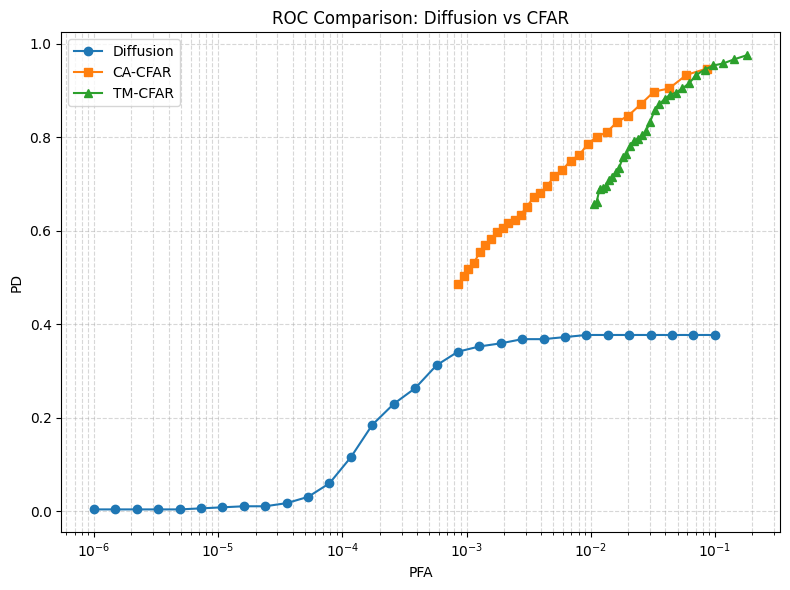

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ————————————————————————————————————————————————
# 1) CFAR‐ROC simulation
# ————————————————————————————————————————————————
def simulate_cfar_roc(cfar_func,
                      dataset,
                      num_train,
                      num_guard,
                      pfa_list,
                      trim_ratio=None):
    """
    Returns empirical (Pfa_emp, Pd_emp) pairs for a given CFAR function.
    - cfar_func: either ca_cfar_2d or tm_cfar_2d
    - dataset: same as in diffusion ROC (returns label_map at idx[6])
    - trim_ratio: only used by TM-CFAR; ignored for CA-CFAR
    """
    # Initialize accumulators
    pfa_emp = []
    pd_emp  = []

    # Precompute total positives/negatives over all frames
    total_pos = 0
    total_neg = 0
    N = 100 #len(dataset if hasattr(dataset, '__len__') else range(100))
    # First pass: count total pos/neg pixels
    for idx in range(N):
        # extract true label map
        label = dataset[idx][6].numpy().astype(bool)  # boolean mask
        total_pos += label.sum()
        total_neg += (~label).sum()

    # For each desired Pfa value
    for Pfa in pfa_list:
        tp = 0
        fp = 0

        # loop frames
        for idx in range(N):
            # get complex RD map and true labels
            RDs_norm = dataset[idx][3]               # torch.complex tensor, (H,W)
            signal    = torch.abs(RDs_norm).numpy()  # real magnitude for CFAR
            label     = dataset[idx][6].numpy().astype(bool)

            # run CFAR
            if trim_ratio is None:
                detect = ca_cfar_2d(signal, num_train, num_guard, Pfa)
            else:
                detect = tm_cfar_2d(signal, num_train, num_guard, trim_ratio, Pfa)

            # accumulate TP and FP
            tp += np.logical_and(detect==1, label).sum()
            fp += np.logical_and(detect==1, ~label).sum()

        # empirical rates
        pd_emp.append(tp / total_pos)
        pfa_emp.append(fp / total_neg)

    return np.array(pfa_emp), np.array(pd_emp)


# ————————————————————————————————————————————————
# 2) Diffusion ROC (your existing function)
# ————————————————————————————————————————————————
def simulate_diffusion_roc(cond_diffusion, dataset, checkpoint, device, pfa_list):
    cond_diffusion.load_state_dict(torch.load(checkpoint, map_location=device))
    cond_diffusion.to(device).eval()

    all_scores = []
    all_labels = []

    # infer shape
    H, W = dataset[0][3].shape
    sample_shape = (1, 2, H, W)

    with torch.no_grad():
        for idx in range(100):
            _, _, _, RDs_norm, _, _, label_map, _ = dataset[idx]
            cond_img = torch.cat([
                RDs_norm.real.unsqueeze(0),
                RDs_norm.imag.unsqueeze(0)
            ], dim=0).unsqueeze(0).to(device)

            gen = cond_diffusion.sample(cond_img, sample_shape)
            gen_complex = torch.complex(gen[0,0], gen[0,1]).cpu().numpy()

            all_scores.append(np.abs(gen_complex).ravel())
            all_labels.append(label_map.numpy().ravel())

    scores = np.concatenate(all_scores)
    labels = np.concatenate(all_labels).astype(bool)

    # background / foreground
    bg = scores[~labels]
    fg = scores[ labels]

    # thresholds for desired pfa_list
    thresh = np.percentile(bg, 100*(1 - np.array(pfa_list)))
    pd_list = [(fg >= t).sum() / len(fg) for t in thresh]

    return np.array(pfa_list), np.array(pd_list)


# ————————————————————————————————————————————————
# 3) Run all three and plot
# ————————————————————————————————————————————————
# parameters
num_train  = 4
num_guard  = 1
trim_ratio = 0.25
checkpoint = "/home/hawk/Desktop/Heavy-Clutter-Detection/Thesis/Full-beta_end_0.01.pth"
device     = torch.device('cuda')
pfa_list   = np.logspace(-6, -1, num=30)

# diffusion
pfa_diff, pd_diff = simulate_diffusion_roc(
    cond_diffusion, norm_val_dataset, checkpoint, device, pfa_list
)

# CA-CFAR
pfa_ca, pd_ca = simulate_cfar_roc(
    ca_cfar_2d, norm_val_dataset,
    num_train, num_guard,
    pfa_list
)

# TM-CFAR
pfa_tm, pd_tm = simulate_cfar_roc(
    tm_cfar_2d, norm_val_dataset,
    num_train, num_guard,
    pfa_list,
    trim_ratio=trim_ratio
)

# plot
plt.figure(figsize=(8,6))
plt.semilogx(pfa_diff, pd_diff, marker='o', label='Diffusion')
plt.semilogx(pfa_ca,   pd_ca,   marker='s', label='CA-CFAR')
plt.semilogx(pfa_tm,   pd_tm,   marker='^', label='TM-CFAR')
plt.xlabel('PFA')
plt.ylabel('PD')
plt.title('ROC Comparison: Diffusion vs CFAR')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Loaded range model successfully
Loaded doppler model successfully
Range‐net output shape: torch.Size([1, 64])
Doppler‐net output shape: torch.Size([1, 64])


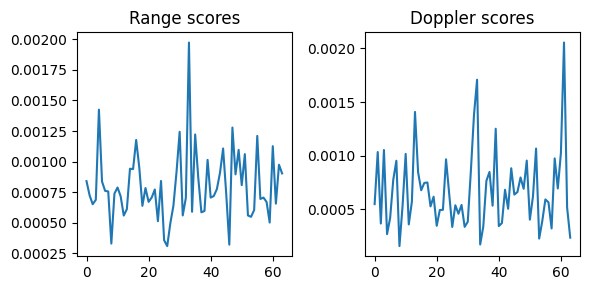

In [ ]:
import torch
import matplotlib.pyplot as plt
from dafc import DAFCRadarNet
from torch.utils.data import DataLoader

# 1. Load your models
range_model, doppler_model = load_trained_models()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
range_model, doppler_model = range_model.to(device), doppler_model.to(device)

# 2. Pick an index
idx = 0   # e.g. the first sample in the validation set

# 3. Unpack that one sample
signals_norm, rd_signals_norm, IQs_norm, RDs_norm, clutter_all, gauss_all, labels, scnr_dBs = norm_val_dataset[idx]

# 4. Prepare the network input: your “X” is IQs_norm, shape (2, N, K)
#    we just need a batch dimension of size 1
X = IQs_norm.unsqueeze(0).to(device)   # → (1, 2, N, K)

# 5. Run inference
range_model.eval(); doppler_model.eval()
with torch.no_grad():
    Y_r = range_model(X)    # → (1, N) or whatever your range‐net outputs
    Y_v = doppler_model(X)  # → (1, K)

print(f"Range‐net output shape: {Y_r.shape}")
print(f"Doppler‐net output shape: {Y_v.shape}")

# 6. (Optional) Visualize the raw score maps:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Range scores")
plt.plot(Y_r.cpu().squeeze().numpy())
plt.subplot(1,2,2)
plt.title("Doppler scores")
plt.plot(Y_v.cpu().squeeze().numpy())
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import torch
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def simulate_nn_roc(range_model, doppler_model, dataset, device, pfa_list):
    """
    Runs your range & doppler nets over every sample, beamforms a per-cell score,
    and computes global ROC statistics.

    Returns:
        pfa_list (array): the input PFA points
        pd_list  (array): the corresponding interpolated PD values
    """
    range_model.eval()
    doppler_model.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        for idx in range(100):
            # unpack one sample
            signals_norm, rd_signals_norm, IQs_norm, RDs_norm, clutter_all, gauss_all, labels, scnr_dBs = dataset[idx]

            # 1×2×N×K input
            X = IQs_norm.unsqueeze(0).to(device)

            # network outputs
            Y_r = range_model(X).cpu().squeeze().numpy()   # shape (N,)
            Y_v = doppler_model(X).cpu().squeeze().numpy() # shape (K,)

            # build a detection‐score map of shape (N,K)
            # here we weight each RD‐cell by the outer product of the two nets
            # you could also include RDs_norm if desired (e.g. multiply by |RD|)
            detection_map = np.outer(Y_r, Y_v)

            # flatten scores and labels
            all_scores.extend(detection_map.ravel().tolist())
            all_labels.extend(labels.ravel().tolist())

    # compute global ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)

    # interpolate TPR at each desired PFA
    pd_list = np.interp(pfa_list, fpr, tpr)

    return pfa_list, pd_list

# -------------------------
# Usage
# -------------------------
# 1) pick your PFA points
pfa_list = np.logspace(-6, -1, 30)

# 2) run the simulation
pfa_nn, pd_nn = simulate_nn_roc(
    range_model, doppler_model,
    norm_val_dataset, device,
    pfa_list
)

# 3) plot PD vs PFA
plt.figure(figsize=(6,4))
plt.loglog(pfa_nn, pd_nn, marker='o', label='NN beamformer')
plt.xlabel('PFA')
plt.ylabel('PD')
plt.title('PD vs. PFA for Range+Doppler NN Detector')
plt.grid(which='both', ls='--', alpha=0.5)
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'sklearn'

Loaded range model successfully
Loaded doppler model successfully


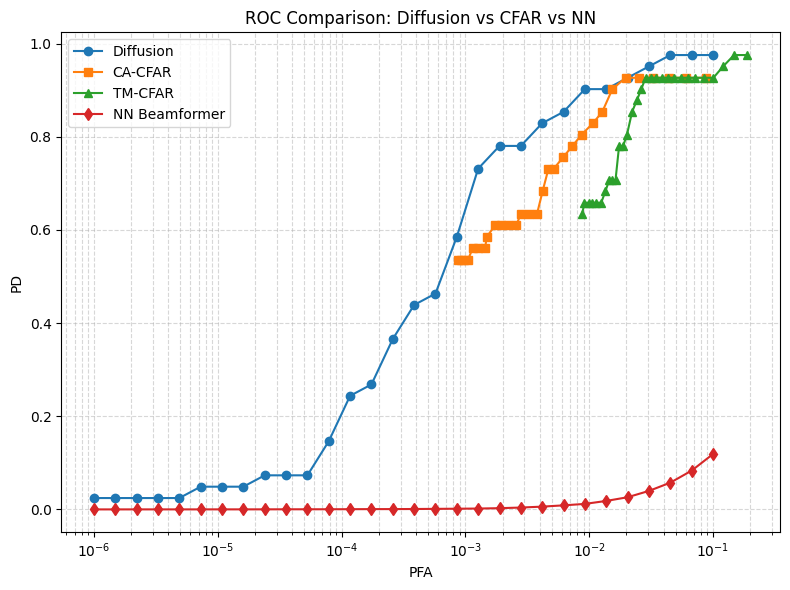

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from dafc import DAFCRadarNet  # or wherever your models live

# ————————————————————————————————————————————————
# 0) your simulate_nn_roc helper
# ————————————————————————————————————————————————
def simulate_nn_roc(range_model, doppler_model, dataset, device, pfa_list):
    range_model.eval(); doppler_model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for idx in range(len(dataset)):
            # unpack
            _, _, IQs_norm, _, _, _, label_map, _ = dataset[idx]
            X = IQs_norm.unsqueeze(0).to(device)        # (1,2,N,K)
            Y_r = range_model(X).cpu().squeeze().numpy()   # (N,)
            Y_v = doppler_model(X).cpu().squeeze().numpy() # (K,)

            # beamform score map
            det_map = np.outer(Y_r, Y_v)
            all_scores.append(det_map.ravel())
            all_labels.append(label_map.numpy().ravel())

    scores = np.concatenate(all_scores)
    labels = np.concatenate(all_labels).astype(bool)

    # split background (negatives) and foreground (positives)
    bg = scores[~labels]
    fg = scores[labels]

    # for each target PFA, pick threshold and compute Pd
    # note: percentile takes 0–100, so we do 100*(1 − pfa)
    thresholds = np.percentile(bg, 100 * (1 - pfa_list))
    pd_list = np.array([(fg >= th).sum() / len(fg) for th in thresholds])

    return np.array(pfa_list), pd_list


# ————————————————————————————————————————————————
# 1) your existing simulate_cfar_roc
# ————————————————————————————————————————————————
def simulate_cfar_roc(cfar_func, dataset, num_train, num_guard,
                      pfa_list, trim_ratio=None):
    pfa_emp = []; pd_emp = []
    # count totals
    total_pos = total_neg = 0
    N = 10
    for idx in range(N):
        label = dataset[idx][6].numpy().astype(bool)
        total_pos += label.sum()
        total_neg += (~label).sum()

    for Pfa in pfa_list:
        tp = fp = 0
        for idx in range(N):
            RDs_norm = dataset[idx][3]
            mag = torch.abs(RDs_norm).numpy()
            label = dataset[idx][6].numpy().astype(bool)

            if trim_ratio is None:
                det = ca_cfar_2d(mag, num_train, num_guard, Pfa)
            else:
                det = tm_cfar_2d(mag, num_train, num_guard, trim_ratio, Pfa)

            tp += np.logical_and(det==1, label).sum()
            fp += np.logical_and(det==1, ~label).sum()

        pd_emp.append(tp/total_pos)
        pfa_emp.append(fp/total_neg)

    return np.array(pfa_emp), np.array(pd_emp)

# ————————————————————————————————————————————————
# 2) your existing simulate_diffusion_roc
# ————————————————————————————————————————————————
def simulate_diffusion_roc(cond_diffusion, dataset, checkpoint, device, pfa_list):
    cond_diffusion.load_state_dict(torch.load(checkpoint, map_location=device))
    cond_diffusion.to(device).eval()

    all_scores = []; all_labels = []
    H, W = dataset[0][3].shape
    sample_shape = (1,2,H,W)

    with torch.no_grad():
        for idx in range(10):
            _, _, _, RDs_norm, _, _, label_map, _ = dataset[idx]
            cond_img = torch.cat([
                RDs_norm.real.unsqueeze(0),
                RDs_norm.imag.unsqueeze(0)
            ], dim=0).unsqueeze(0).to(device)

            gen = cond_diffusion.sample(cond_img, sample_shape)
            gen_c = torch.complex(gen[0,0], gen[0,1]).cpu().numpy()

            all_scores.append(np.abs(gen_c).ravel())
            all_labels.append(label_map.numpy().ravel())

    scores = np.concatenate(all_scores)
    labels = np.concatenate(all_labels).astype(bool)
    bg = scores[~labels]; fg = scores[labels]

    thresh = np.percentile(bg, 100*(1 - pfa_list))
    pd_list = [(fg>=t).sum()/len(fg) for t in thresh]
    return np.array(pfa_list), np.array(pd_list)

# ————————————————————————————————————————————————
# 3) load models & set params
# ————————————————————————————————————————————————
# NN models
range_model, doppler_model = load_trained_models()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
range_model, doppler_model = range_model.to(device), doppler_model.to(device)

# diffusion model
#cond_diffusion = ConditionalDiffusion(...)  # init "/home/hawk/.../comp1-reg_diff_snr10_cnr15.pth"
trim_ratio = 0.25

# dataset & checkpoint
dataset    = norm_val_dataset
checkpoint = "/home/hawk/Desktop/Heavy Detector/Heavy-Clutter-Detection/finalDiffusion/comp1-reg_diff_snr10_cnr15.pth"
pfa_list   = np.logspace(-6, -1, num=30)

# ————————————————————————————————————————————————
# 4) run all ROC sims
# ————————————————————————————————————————————————
pfa_nn, pd_nn       = simulate_nn_roc(range_model, doppler_model,
                                      dataset, device, pfa_list)
pfa_diff, pd_diff   = simulate_diffusion_roc(cond_diffusion,
                                             dataset, checkpoint,
                                             device, pfa_list)
pfa_ca,  pd_ca      = simulate_cfar_roc(ca_cfar_2d, dataset,
                                        num_train, num_guard,
                                        pfa_list)
pfa_tm,  pd_tm      = simulate_cfar_roc(tm_cfar_2d, dataset,
                                        num_train, num_guard,
                                        pfa_list, trim_ratio=trim_ratio)

# ————————————————————————————————————————————————
# 5) plot them together
# ————————————————————————————————————————————————
plt.figure(figsize=(8,6))
plt.semilogx(pfa_diff, pd_diff, marker='o', label='Diffusion')
plt.semilogx(pfa_ca,   pd_ca,   marker='s', label='CA-CFAR')
plt.semilogx(pfa_tm,   pd_tm,   marker='^', label='TM-CFAR')
plt.semilogx(pfa_nn,   pd_nn,   marker='d', label='NN Beamformer')
plt.xlabel('PFA'); plt.ylabel('PD')
plt.title('ROC Comparison: Diffusion vs CFAR vs NN')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend(); plt.tight_layout()
plt.show()
